In [1]:
!echo "wireshark-common wireshark-common/install-setuid boolean true" | debconf-set-selections
!apt update
!DEBIAN_FRONTEND=noninteractive apt-get install tshark build-essential -y
!python3 -m pip install pip --upgrade
!python3 -m pip install wheel --upgrade
!python3 -m pip install buildtools --upgrade

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease                   
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]  
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]3m
Fetched 336 kB in 2s (141 kB/s)                                 33m
Reading package lists... Done
Building dependency tree       
Reading state information... Done
36 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
tshark is already the newest version (3.2.3-1).
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [2]:
%pip install tqdm nest-asyncio matplotlib mlxtend pyshark

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import zipfile
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pyshark
import nest_asyncio
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from mlxtend.plotting import plot_confusion_matrix
from tensorflow import keras
nest_asyncio.apply()

In [4]:
pcaps_urls = [
    'https://www.malware-traffic-analysis.net/2019/07/25/2019-07-25-Hancitor-style-Amadey-with-Pony-and-Cobalt-Strike.pcap.zip',
    'https://www.malware-traffic-analysis.net/2020/12/15/2020-12-15-Qakbot-infection-part-2-with-Cobalt-Strike.pcap.zip',
    'https://www.malware-traffic-analysis.net/2020/12/07/2020-12-07-Qakbot-with-Cobalt-Strike-and-spambot-activity.pcap.zip',
    'https://www.malware-traffic-analysis.net/2022/07/27/2022-07-27-IcedID-infections-2-pcaps.zip',
    'https://www.malware-traffic-analysis.net/2022/07/26/2022-07-26-IcedID-with-DarkVNC-and-Cobalt-Strike-carved.pcap.zip',
    'https://www.malware-traffic-analysis.net/2022/07/25/2022-07-25-IcedID-with-Cobalt-Strike-carved.pcap.zip',
    'https://www.malware-traffic-analysis.net/2022/07/21/2022-07-22-IcedID-with-DarkVNC-and-Cobalt-Strike.pcap.zip',
    'https://www.malware-traffic-analysis.net/2022/07/07/2022-07-07-Emotet-infection-with-Cobalt-Strike.pcap.zip',
    'https://www.malware-traffic-analysis.net/2022/07/06/2022-07-06-TA578-Contact-Forms-IcedID-with-DarkVNC-and-Cobalt-Strike.pcap.zip'
    ]
extracted_pcaps = []
for pcaps_url in pcaps_urls:
    split_pcap = pcaps_url.split('/')
    pcap_zip_filename = split_pcap[-1]
    if os.path.exists(pcap_zip_filename) == False:
        print('Downloading: ' + pcaps_url)
        response = requests.get(pcaps_url)
        open(pcap_zip_filename, "wb").write(response.content)
    zip = zipfile.ZipFile(pcap_zip_filename)
    for extracted_pcap in zip.namelist():
        if os.path.exists(extracted_pcap) == False:
            print('Extracting: ' + pcap_zip_filename)
            zip.extractall(pwd=b'infected')
            break
    for extracted_pcap in zip.namelist():
        extracted_pcaps.append(extracted_pcap)
        print('Running tshark TCP conversations: ' + extracted_pcap)
        os.system('tshark -r ' + extracted_pcap + ' -Qz "conv,tcp" > ' + extracted_pcap + '.txt')

Running tshark TCP conversations: 2019-07-25-Hancitor-style-Amadey-with-Pony-and-Cobalt-Strike.pcap


Running as user "root" and group "root". This could be dangerous.


Downloading: https://www.malware-traffic-analysis.net/2020/12/15/2020-12-15-Qakbot-infection-part-2-with-Cobalt-Strike.pcap.zip
Extracting: 2020-12-15-Qakbot-infection-part-2-with-Cobalt-Strike.pcap.zip
Running tshark TCP conversations: 2020-12-15-Qakbot-infection-part-2-with-Cobalt-Strike.pcap


Running as user "root" and group "root". This could be dangerous.


Running tshark TCP conversations: 2020-12-07-Qakbot-with-Cobalt-Strike-and-spambot-activity.pcap


Running as user "root" and group "root". This could be dangerous.


Running tshark TCP conversations: 2022-07-27-first-run-IcedID-infection-traffic.pcap
Running tshark TCP conversations: 2022-07-27-second-run-IcedID-infection-traffic.pcap


Running as user "root" and group "root". This could be dangerous.
Running as user "root" and group "root". This could be dangerous.


Running tshark TCP conversations: 2022-07-26-IcedID-with-DarkVNC-and-Cobalt-Strike-carved.pcap
Running tshark TCP conversations: 2022-07-25-IcedID-with-Cobalt-Strike-carved.pcap


Running as user "root" and group "root". This could be dangerous.
Running as user "root" and group "root". This could be dangerous.


Running tshark TCP conversations: 2022-07-22-IcedID-with-DarkVNC-and-Cobalt-Strike.pcap


Running as user "root" and group "root". This could be dangerous.


Running tshark TCP conversations: 2022-07-07-Emotet-infection-with-Cobalt-Strike.pcap
Running tshark TCP conversations: 2022-07-06-TA578-Contact-Forms-IcedID-with-DarkVNC-and-Cobalt-Strike.pcap


Running as user "root" and group "root". This could be dangerous.
Running as user "root" and group "root". This could be dangerous.


In [5]:
pcapBytesReceived = {}
pcapBytesSent = {}
for inputFilePath in extracted_pcaps:
  bytesReceivedForPorts = [0] * 66000
  bytesSentForPorts = [0] * 66000
  f = open(inputFilePath + '.txt', mode="r")
  for line in f:
    if not line[0].isnumeric():
      continue
    splitLine = line.split()
    source = splitLine[0]
    splitSource = source.split(':')
    sourcePort = int(splitSource[1])
    bytesReceivedForPorts[sourcePort] = int(splitLine[4])
    bytesSentForPorts[sourcePort] = int(splitLine[6])
  pcapBytesReceived[inputFilePath] = bytesReceivedForPorts
  pcapBytesSent[inputFilePath] = bytesSentForPorts

In [6]:
def getLastTCPAckSequence(inputFilePath):
  tcpStreamLastPacketIPSrc = [''] * 100000 # List that maps TCP Stream ID to ACK Number
  tcpStreamLastPacketAck = [0] * 100000 # List that maps TCP Stream ID to ACK Number
  tcpStreamLastPacketSequence = [0] * 100000 # List that maps TCP Stream ID to ACK Number
  capture = pyshark.FileCapture(inputFilePath, display_filter='tcp') # filter to display only TCP
  for packet in tqdm(capture): # display progress bar
    streamId = int(packet.tcp.stream)
    tcpStreamLastPacketIPSrc[streamId] = str(packet.ip.src)
    tcpStreamLastPacketAck[streamId] = int(packet.tcp.ack) # Total bytes Received
    tcpStreamLastPacketSequence[streamId] = int(packet.tcp.seq) # Total bytes Sent
  return tcpStreamLastPacketIPSrc, tcpStreamLastPacketAck, tcpStreamLastPacketSequence

def getBytesReceivedSent(streamId, ipsrc, ipdst, tcpStreamLastPacketIPSrc, tcpStreamLastPacketAck, tcpStreamLastPacketSequence):
  lastPacketIPSrc = tcpStreamLastPacketIPSrc[streamId]
  if lastPacketIPSrc == ipsrc:
    bytesReceived = tcpStreamLastPacketAck[streamId]
    bytesSent = tcpStreamLastPacketSequence[streamId]
    return bytesReceived, bytesSent
  if lastPacketIPSrc == ipdst:
    bytesSent = tcpStreamLastPacketAck[streamId]
    bytesReceived = tcpStreamLastPacketSequence[streamId]
    return bytesReceived, bytesSent
  print("warning: no matching IP found for:" + lastPacketIPSrc + " in tcp stream:" + str(streamId))
  return 0, 0

def getTimeDeltas(inputFilePath, bytesReceivedForPorts=None, bytesSentForPorts=None, tcpStreamLastPacketIPSrc=None, tcpStreamLastPacketAck=None, tcpStreamLastPacketSequence=None):
  lastTimeStamps = {}
  timeDeltasPerFlow = {}
  totalBytesSentPerFlow = {}
  totalBytesReceievedPerFlow = {}
  capture = pyshark.FileCapture(inputFilePath, display_filter='tcp.flags.syn == 1') # filter to display only SYN packets
  for packet in tqdm(capture): # display progress bar
    ipsrc = str(packet.ip.src)
    ipdst = str(packet.ip.dst)
    dstport = str(packet.tcp.dstport)
    # create a unique string to represent this flow. this will be used as key in dictionary
    flowName = "Src IP: " + ipsrc + " " + "Dest: " + ipdst + ":" + dstport
    timestampFloat = float(packet.sniff_timestamp)
    lastTimeStamp = lastTimeStamps.get(flowName) # get time stamp of latest packet sent in this flow
    if lastTimeStamp: # if this is not the first packet seen in this flow
      timeDelta = timestampFloat - lastTimeStamp # Number of seconds since last packet, based on TCP SYN
      timeDeltas = timeDeltasPerFlow.setdefault(flowName, []) # create a new list for this flow, if it does not exist
      timeDeltas.append(timeDelta) # append Time Delta to list
      streamId = int(packet.tcp.stream)
      totalBytesSent = totalBytesSentPerFlow.setdefault(flowName, []) # create a new list for this flow, if it does not exist
      totalBytesReceived = totalBytesReceievedPerFlow.setdefault(flowName, []) # create a new list for this flow, if it does not exist
      if bytesReceivedForPorts is not None:
        sourcePort = int(packet.tcp.srcport)
        bytesReceived = bytesReceivedForPorts[sourcePort]
        bytesSent = bytesSentForPorts[sourcePort]
      else:
        bytesReceived, bytesSent = getBytesReceivedSent( \
          streamId, ipsrc, ipdst, tcpStreamLastPacketIPSrc, tcpStreamLastPacketAck, tcpStreamLastPacketSequence)
      totalBytesSent.append(bytesSent)
      totalBytesReceived.append(bytesReceived)
    lastTimeStamps[flowName] = timestampFloat # set Timestamp for calculating next Time Delta
  return timeDeltasPerFlow, totalBytesSentPerFlow, totalBytesReceievedPerFlow

combinedTimeDeltasPerFlow = {}
combinedTotalBytesSentPerFlow = {}
combinedTotalBytesReceivedPerFlow = {}

for inputFilePath in extracted_pcaps:
  timeDeltasPerFlow, totalBytesSentPerFlow, totalBytesReceievedPerFlow = \
    getTimeDeltas(inputFilePath, 
                  bytesReceivedForPorts=pcapBytesReceived[inputFilePath],
                  bytesSentForPorts=pcapBytesSent[inputFilePath])
  
  combinedTimeDeltasPerFlow.update(timeDeltasPerFlow)
  combinedTotalBytesSentPerFlow.update(totalBytesSentPerFlow)
  combinedTotalBytesReceivedPerFlow.update(totalBytesReceievedPerFlow)

22602it [00:21, 1068.49it/s]
10378it [00:09, 1044.17it/s]
849it [00:01, 649.31it/s]
52it [00:00, 157.74it/s]
30it [00:00, 94.47it/s]
54it [00:00, 142.04it/s]
314it [00:00, 481.95it/s]
1273it [00:01, 822.19it/s] 
318it [00:00, 482.14it/s]
1449it [00:01, 745.98it/s]


In [7]:
# print sample of data for one single flow
flowName = next(x for x in combinedTimeDeltasPerFlow.keys())
print(flowName)
print(combinedTimeDeltasPerFlow[flowName][0:5])
print(combinedTotalBytesSentPerFlow[flowName][0:5])
print(combinedTotalBytesReceivedPerFlow[flowName][0:5])

Src IP: 10.7.25.101 Dest: 77.120.115.221:80
[1.1069128513336182, 59.60028409957886, 0.885612964630127, 59.606709003448486, 0.9056601524353027]
[513, 514, 513, 514, 513]
[471, 471, 471, 471, 471]


In [8]:
def getFilteredTimeDeltas(minimumPacketCount, timeDeltasPerFlow):
  beaconScorePerFlow = {}
  timeDeltasFilteredPerFlow = {}
  for flowName, timeDeltas in tqdm(timeDeltasPerFlow.items()):
      if len(timeDeltas) >= minimumPacketCount:
          timeDeltasNumpy = np.array(timeDeltas)
          median = np.percentile(timeDeltasNumpy, 50)
          upperQuartile = np.percentile(timeDeltasNumpy, 75) # 75% of datapoints are less than this number
          lowerQuartile = np.percentile(timeDeltasNumpy, 25) # 25% of datapoints are less than this number
          interquartileRange = upperQuartile - lowerQuartile
          lowerLimit = lowerQuartile - interquartileRange
          upperLimit = upperQuartile + interquartileRange
          filteredIndicies = np.where(np.logical_and(timeDeltasNumpy>=lowerLimit, timeDeltasNumpy<=upperLimit))
          filteredList = timeDeltasNumpy[filteredIndicies]
          standardDeviation = np.std(filteredList)
          print(flowName)
          beaconScorePerFlow[flowName] = median / max(1, standardDeviation)
          timeDeltasFilteredPerFlow[flowName] = filteredList
  return beaconScorePerFlow, timeDeltasFilteredPerFlow

minimumPacketCount = 10
beaconScorePerFlow, timeDeltasFilteredPerFlow = \
getFilteredTimeDeltas(minimumPacketCount, combinedTimeDeltasPerFlow) # filter out flows that have fewer than 20 connections

100%|██████████| 148/148 [00:00<00:00, 14018.59it/s]

Src IP: 10.7.25.101 Dest: 77.120.115.221:80
Src IP: 10.7.25.101 Dest: 83.220.175.185:80
Src IP: 10.7.25.101 Dest: 31.44.184.33:80
Src IP: 10.12.15.101 Dest: 78.101.199.138:995
Src IP: 10.12.15.101 Dest: 10.12.15.15:389
Src IP: 10.12.15.101 Dest: 10.12.15.15:445
Src IP: 10.12.15.101 Dest: 10.12.15.15:135
Src IP: 10.12.15.101 Dest: 10.12.15.15:49667
Src IP: 10.12.15.101 Dest: 185.125.206.173:8080
Src IP: 10.12.15.101 Dest: 172.241.27.244:443
Src IP: 10.12.15.101 Dest: 172.241.27.244:80
Src IP: 10.12.15.101 Dest: 185.125.206.173:443
Src IP: 10.12.15.101 Dest: 172.241.27.244:8888
Src IP: 10.12.15.101 Dest: 95.76.27.6:443
Src IP: 10.12.7.101 Dest: 10.12.7.7:88
Src IP: 10.12.7.101 Dest: 10.12.7.7:389
Src IP: 10.12.7.101 Dest: 23.106.160.137:80
Src IP: 10.12.7.101 Dest: 23.106.160.138:8888
Src IP: 10.12.7.101 Dest: 173.201.192.101:465
Src IP: 10.7.27.101 Dest: 149.154.152.42:443
Src IP: 10.7.27.102 Dest: 165.227.210.86:443
Src IP: 10.7.26.101 Dest: 108.62.118.133:443
Src IP: 10.7.25.2 Dest: 1

Src IP: 10.12.15.101 Dest: 10.12.15.15:445


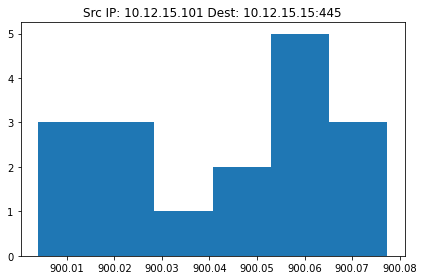

Src IP: 10.12.15.101 Dest: 95.76.27.6:443


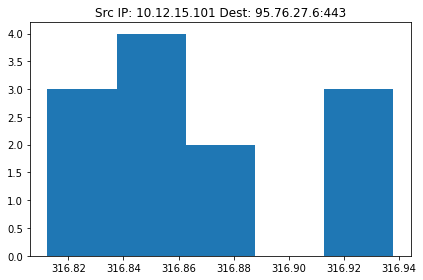

Src IP: 10.7.22.101 Dest: 149.154.152.42:443


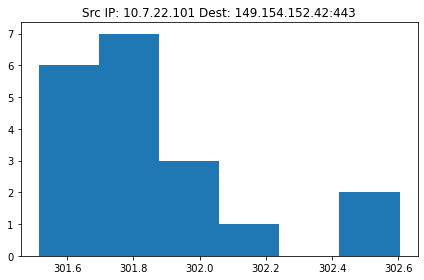

Src IP: 10.7.22.101 Dest: 188.93.233.241:443


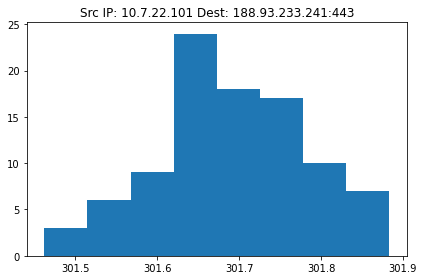

Src IP: 10.7.27.101 Dest: 149.154.152.42:443


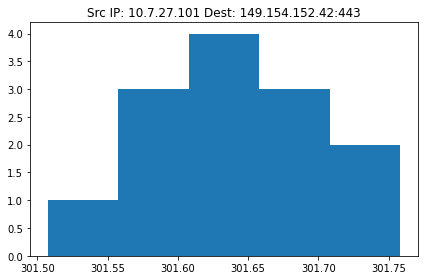

Src IP: 10.7.27.102 Dest: 165.227.210.86:443


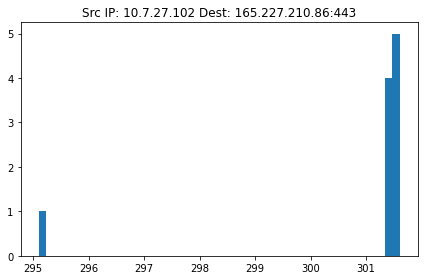

Src IP: 10.7.25.101 Dest: 83.220.175.185:80


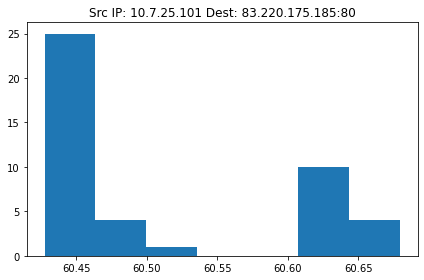

Src IP: 10.12.7.101 Dest: 23.106.160.138:8888


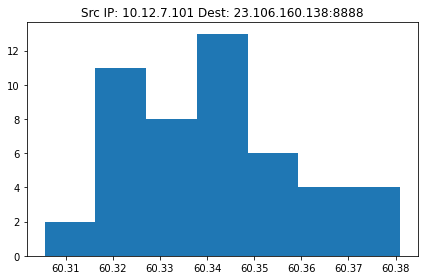

Src IP: 10.12.7.101 Dest: 23.106.160.137:80


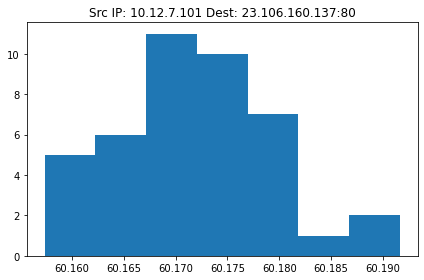

Src IP: 10.7.22.101 Dest: 10.7.22.22:445


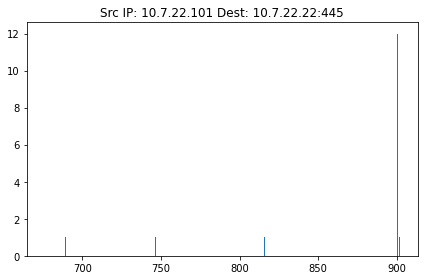

Src IP: 10.7.7.101 Dest: 52.18.235.51:443


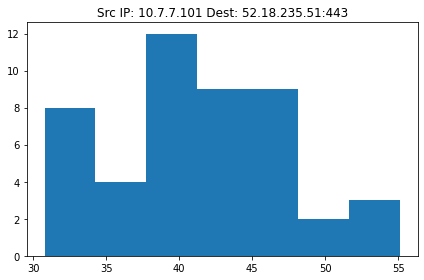

Src IP: 10.12.15.101 Dest: 185.125.206.173:8080


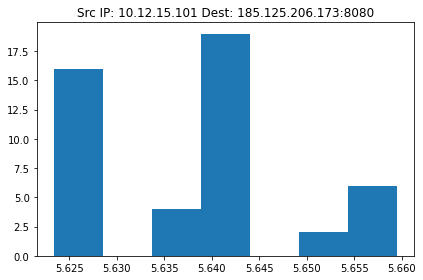

Src IP: 10.7.25.2 Dest: 172.93.193.21:443


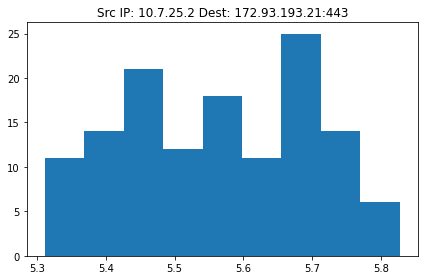

Src IP: 10.7.22.101 Dest: 194.135.24.240:443


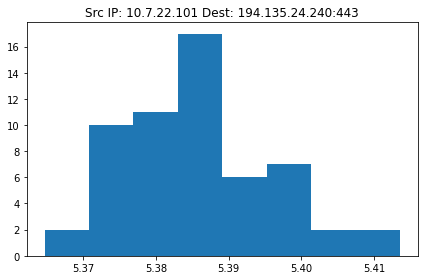

Src IP: 10.12.15.101 Dest: 185.125.206.173:443


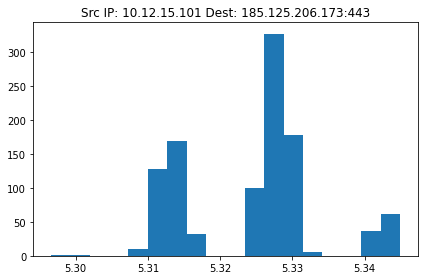

Src IP: 10.12.15.101 Dest: 172.241.27.244:443


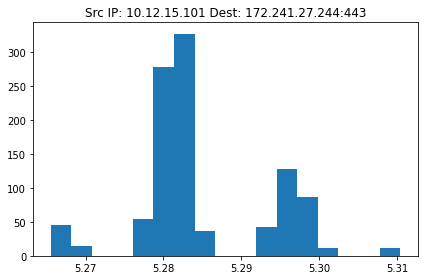

Src IP: 10.12.15.101 Dest: 172.241.27.244:8888


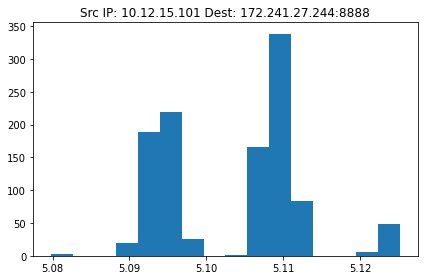

Src IP: 10.12.15.101 Dest: 172.241.27.244:80


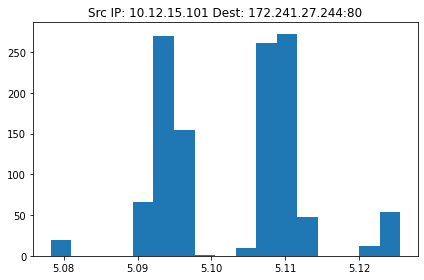

Src IP: 10.7.22.101 Dest: 212.114.52.91:8080


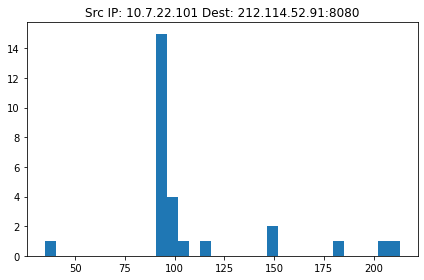

Src IP: 10.7.26.101 Dest: 108.62.118.133:443


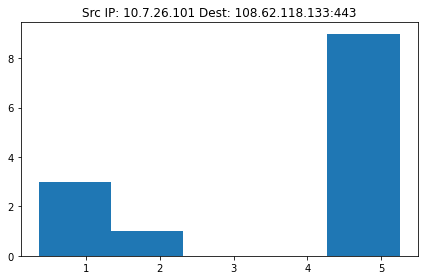

Src IP: 10.12.15.101 Dest: 78.101.199.138:995


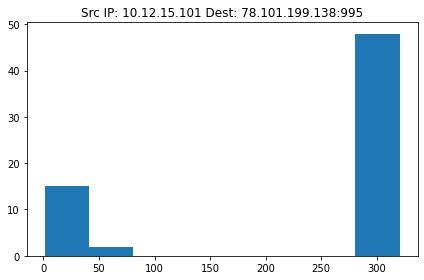

Src IP: 10.7.1.7 Dest: 198.44.132.80:8080


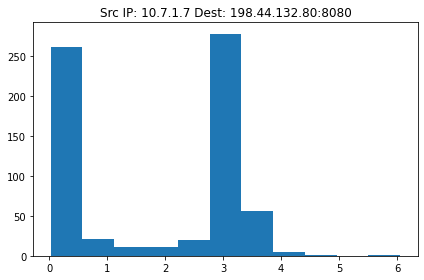

Src IP: 10.7.1.7 Dest: 92.38.171.191:443


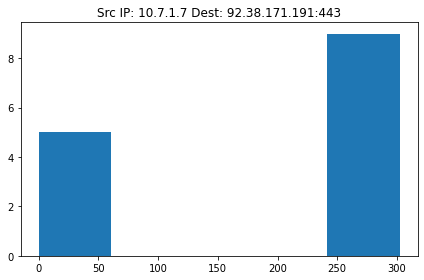

Src IP: 10.12.15.101 Dest: 10.12.15.15:49667


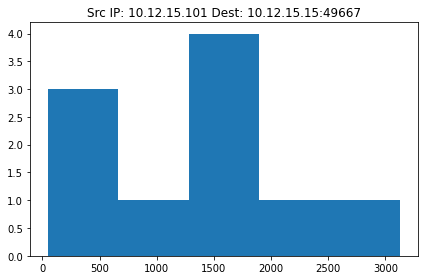

Src IP: 10.12.15.101 Dest: 10.12.15.15:135


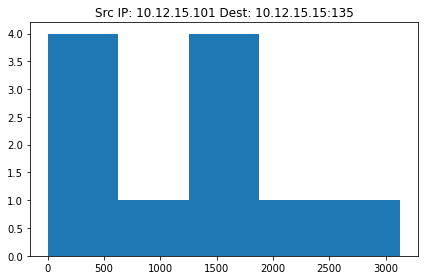

Src IP: 10.7.22.101 Dest: 10.7.22.22:49667


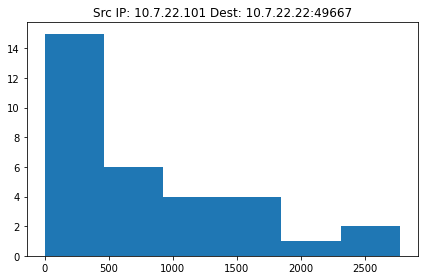

Src IP: 10.12.7.101 Dest: 173.201.192.101:465


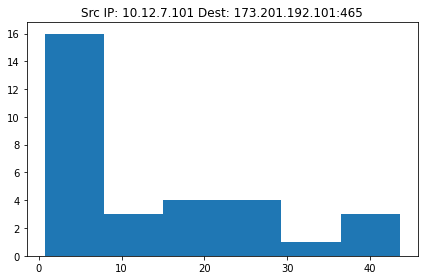

Src IP: 10.7.22.101 Dest: 10.7.22.22:135


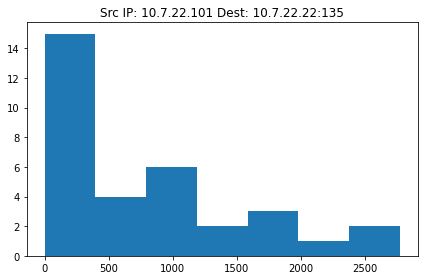

Src IP: 10.7.7.101 Dest: 164.90.222.65:443


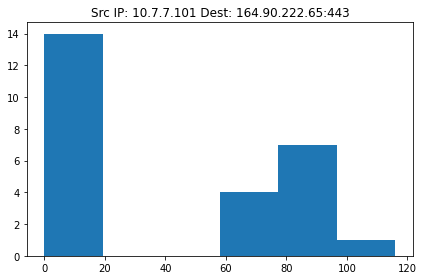

Src IP: 10.7.25.101 Dest: 31.44.184.33:80


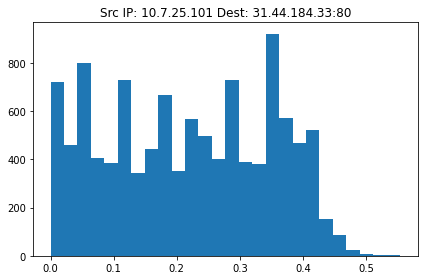

Src IP: 10.12.7.101 Dest: 10.12.7.7:389


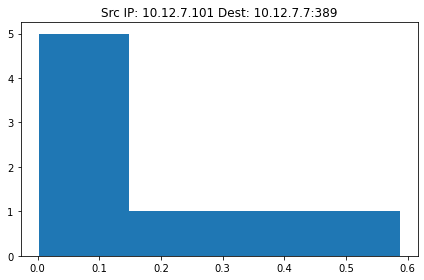

Src IP: 10.7.25.101 Dest: 77.120.115.221:80


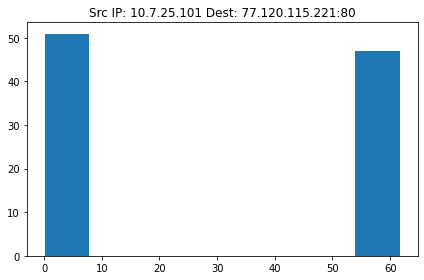

Src IP: 10.12.7.101 Dest: 10.12.7.7:88


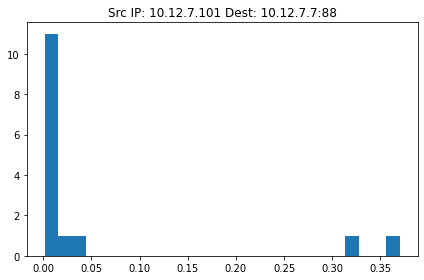

Src IP: 10.7.22.101 Dest: 10.7.22.22:88


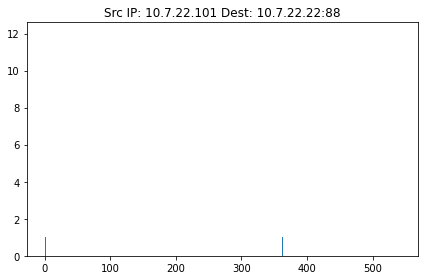

Src IP: 10.7.22.101 Dest: 10.7.22.22:389


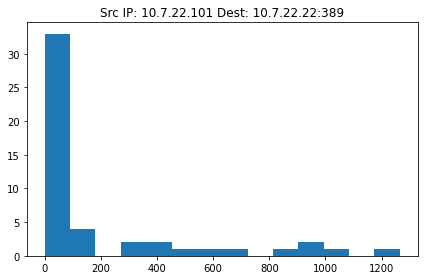

Src IP: 10.12.15.101 Dest: 10.12.15.15:389


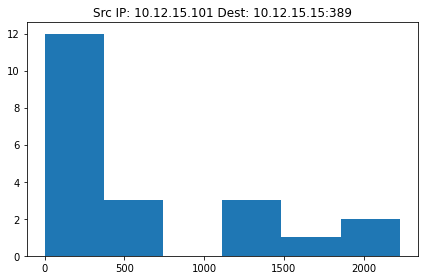

In [9]:
# sort flows, starting with lowest Standard Deviation first
plt.ticklabel_format(style='plain')
plt.ticklabel_format(useOffset=False)
beaconScoreSorted = dict(sorted(beaconScorePerFlow.items(), key=lambda item: item[1], reverse=True))
for flowName in beaconScoreSorted:
  print(flowName)
  x = timeDeltasFilteredPerFlow[flowName] # x-axis is Number of seconds since last packet, based on TCP SYN
  none = plt.hist(x, bins='auto')
  plt.title(flowName)
  plt.tight_layout()    
  plt.show()

In [10]:
# training example dataset
X = []

# training example labels (0 = benign, 1 = malicious)
BENIGN = 0
MALICIOUS = 1
Y = []

labelsToText = ['Benign', 'Malicious']

# break flows into steams containing 10 sequential packets each
timeSteps = 10
maximumPacketsToAnalyzePerFlow = 2000

def appendSplit(flowName, yValue, X, Y, backLabels=None):

  synTimeDeltas = combinedTimeDeltasPerFlow[flowName]
  receivedSizes = combinedTotalBytesReceivedPerFlow[flowName]
  sentSizes = combinedTotalBytesSentPerFlow[flowName]
  maximumPacketsToAnalyze = min (len(synTimeDeltas), maximumPacketsToAnalyzePerFlow)
  print(labelsToText[yValue] + " " + str(maximumPacketsToAnalyze - timeSteps) + " " + flowName)
  for delta in range(maximumPacketsToAnalyze - timeSteps):
    Y.append(yValue)
    if backLabels is not None:
      backLabels.append(flowName)
    xdata = np.array([
      synTimeDeltas[delta: delta + timeSteps], \
      np.log(np.array(receivedSizes[delta: delta + timeSteps])), \
      np.log(np.array(sentSizes[delta: delta + timeSteps])) \
    ])
    X.append(xdata.transpose().tolist())

#2020-12-07-Qakbot
appendSplit("Src IP: 10.12.7.101 Dest: 23.106.160.138:8888", MALICIOUS, X, Y) # 60 - 61 seconds
appendSplit("Src IP: 10.12.7.101 Dest: 23.106.160.137:80", MALICIOUS, X, Y) # 60 - 61 seconds
#appendSplit("Src IP: 10.12.7.101 Dest: 173.201.192.101:465", BENIGN, X, Y) # SMTPS  0 - 40 seconds
appendSplit("Src IP: 10.12.7.101 Dest: 10.12.7.7:389", BENIGN, X, Y) # LDAP  0 - 0.6 seconds
appendSplit("Src IP: 10.12.7.101 Dest: 10.12.7.7:88", BENIGN, X, Y) # Kerberos  0 - 0.35 seconds

#2020-12-15-Qakbot
appendSplit("Src IP: 10.12.15.101 Dest: 95.76.27.6:443", MALICIOUS, X, Y) # 316 - 317 seconds easy to ID
appendSplit("Src IP: 10.12.15.101 Dest: 172.241.27.244:8888", MALICIOUS, X, Y) # 5 - 6 seconds
appendSplit("Src IP: 10.12.15.101 Dest: 185.125.206.173:443", MALICIOUS, X, Y) # 5 - 6 seconds
appendSplit("Src IP: 10.12.15.101 Dest: 185.125.206.173:8080", MALICIOUS, X, Y) # 5 - 6 seconds
appendSplit("Src IP: 10.12.15.101 Dest: 10.12.15.15:49667", BENIGN, X, Y) # 0 - 3000 seconds
appendSplit("Src IP: 10.12.15.101 Dest: 10.12.15.15:135", BENIGN, X, Y) # RPC  0 - 3000 seconds
appendSplit("Src IP: 10.12.15.101 Dest: 172.241.27.244:443", MALICIOUS, X, Y) # 5 - 6 seconds
appendSplit("Src IP: 10.12.15.101 Dest: 172.241.27.244:80", MALICIOUS, X, Y) # 5 - 6 seconds
#appendSplit("Src IP: 10.12.15.101 Dest: 10.12.15.15:445", BENIGN, X, Y) # potential FALSE POS traffic every 15 minutes, likely Active Directory
#appendSplit("Src IP: 10.12.15.101 Dest: 78.101.199.138:995", BENIGN, X, Y) # POP3S every 5 minutes
appendSplit("Src IP: 10.12.15.101 Dest: 10.12.15.15:389", BENIGN, X, Y) # LDAP 0-2000 seconds

#2022-07-27-first
appendSplit("Src IP: 10.7.27.101 Dest: 149.154.152.42:443", MALICIOUS, X, Y) # 301 - 302 seconds

#2022-07-27-second
appendSplit("Src IP: 10.7.27.102 Dest: 165.227.210.86:443", MALICIOUS, X, Y) # 295 - 302 seconds

#2022-07-26-IcedID
appendSplit("Src IP: 10.7.26.101 Dest: 108.62.118.133:443", MALICIOUS, X, Y) # 0 - 6 seconds

#2022-07-25-IcedID
appendSplit("Src IP: 10.7.25.2 Dest: 172.93.193.21:443", MALICIOUS, X, Y) # 5 - 6 seconds

#2019-07-25-Hancitor
appendSplit("Src IP: 10.7.25.101 Dest: 83.220.175.185:80", MALICIOUS, X, Y) # 60 - 61 seconds
appendSplit("Src IP: 10.7.25.101 Dest: 77.120.115.221:80", MALICIOUS, X, Y) # JITTER example: many 0-10 seconds and 50-70 seconds
#appendSplit("Src IP: 10.7.25.101 Dest: 31.44.184.33:80", BENIGN, X_test, Y_test, backLabels=backLabels) # 0 - 0.6 seconds

#2022-07-07-Emotet-infection-with-Cobalt-Strike.pcap
appendSplit("Src IP: 10.7.7.101 Dest: 52.18.235.51:443", MALICIOUS, X, Y) # 30-60 seconds - nice jitter
appendSplit("Src IP: 10.7.7.101 Dest: 164.90.222.65:443", MALICIOUS, X, Y) # 60-120 seconds - nice jitter

#2022-07-06-TA578-Contact-Forms-IcedID-with-DarkVNC-and-Cobalt-Strike.pcap
appendSplit("Src IP: 10.7.1.7 Dest: 198.44.132.80:8080", MALICIOUS, X, Y) # 0-6 seconds
appendSplit("Src IP: 10.7.1.7 Dest: 92.38.171.191:443", MALICIOUS, X, Y) # 0-300 seconds

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.0001, shuffle=True)
backLabels = [''] * len(Y_test)

#appendSplit("Src IP: 10.12.15.101 Dest: 172.241.27.244:443", MALICIOUS, X_test, Y_test, backLabels=backLabels) # 5 - 6 seconds
#appendSplit("Src IP: 10.12.15.101 Dest: 10.12.15.15:389", BENIGN, X_test, Y_test, backLabels=backLabels) # LDAP 0-2000 seconds

#2022-07-22-IcedID-with-DarkVNC-and-Cobalt-Strike.pcap
appendSplit("Src IP: 10.7.22.101 Dest: 149.154.152.42:443", MALICIOUS, X_test, Y_test, backLabels=backLabels) # 300-303 seconds
appendSplit("Src IP: 10.7.22.101 Dest: 188.93.233.241:443", MALICIOUS, X_test, Y_test, backLabels=backLabels) # 300-302 seconds
#appendSplit("Src IP: 10.7.22.101 Dest: 10.7.22.22:445", BENIGN, X_test, Y_test, backLabels=backLabels) # potential FALSE POS traffic every 600-900 seconds, likely Active Directory
appendSplit("Src IP: 10.7.22.101 Dest: 194.135.24.240:443", MALICIOUS, X_test, Y_test, backLabels=backLabels) # 5-6 seconds
appendSplit("Src IP: 10.7.22.101 Dest: 212.114.52.91:8080", MALICIOUS, X_test, Y_test, backLabels=backLabels) # DarkVNC every 100 seconds, significant jitter
appendSplit("Src IP: 10.7.22.101 Dest: 10.7.22.22:49667", BENIGN, X_test, Y_test, backLabels=backLabels) # 0 - 3000 seconds
appendSplit("Src IP: 10.7.22.101 Dest: 10.7.22.22:135", BENIGN, X_test, Y_test, backLabels=backLabels) # RPC  0 - 3000 seconds
appendSplit("Src IP: 10.7.22.101 Dest: 10.7.22.22:88", BENIGN, X_test, Y_test, backLabels=backLabels) # Kerberos  0 - 0.35 seconds and 360 seconds
appendSplit("Src IP: 10.7.22.101 Dest: 10.7.22.22:389", BENIGN, X_test, Y_test, backLabels=backLabels) # Kerberos  0 - 0.35 seconds and 360 seconds



Malicious 43 Src IP: 10.12.7.101 Dest: 23.106.160.138:8888
Malicious 44 Src IP: 10.12.7.101 Dest: 23.106.160.137:80
Benign 0 Src IP: 10.12.7.101 Dest: 10.12.7.7:389
Benign 8 Src IP: 10.12.7.101 Dest: 10.12.7.7:88
Malicious 4 Src IP: 10.12.15.101 Dest: 95.76.27.6:443
Malicious 1168 Src IP: 10.12.15.101 Dest: 172.241.27.244:8888
Malicious 1271 Src IP: 10.12.15.101 Dest: 185.125.206.173:443
Malicious 41 Src IP: 10.12.15.101 Dest: 185.125.206.173:8080
Benign 1 Src IP: 10.12.15.101 Dest: 10.12.15.15:49667
Benign 2 Src IP: 10.12.15.101 Dest: 10.12.15.15:135
Malicious 1144 Src IP: 10.12.15.101 Dest: 172.241.27.244:443
Malicious 1311 Src IP: 10.12.15.101 Dest: 172.241.27.244:80
Benign 13 Src IP: 10.12.15.101 Dest: 10.12.15.15:389
Malicious 7 Src IP: 10.7.27.101 Dest: 149.154.152.42:443
Malicious 3 Src IP: 10.7.27.102 Dest: 165.227.210.86:443
Malicious 3 Src IP: 10.7.26.101 Dest: 108.62.118.133:443
Malicious 134 Src IP: 10.7.25.2 Dest: 172.93.193.21:443
Malicious 40 Src IP: 10.7.25.101 Dest: 83

In [11]:
print(np.array(X).ndim)
print(X_test[19])
print(Y_test[19])

3
[[302.0172789096832, 7.631916513071252, 6.8001700683022], [301.51353788375854, 7.631916513071252, 6.8001700683022], [301.55693197250366, 7.660585461703256, 6.86484777797086], [301.5339300632477, 7.660585461703256, 6.86484777797086], [301.86904096603394, 7.660585461703256, 6.86484777797086], [595.557718038559, 7.717796211013582, 6.930494765951626], [89.4302589893341, 7.717796211013582, 6.930494765951626], [86.39748501777649, 7.717796211013582, 6.930494765951626], [86.47473096847534, 7.780720886117918, 7.074116816197362], [146.77621412277222, 8.217978203150732, 7.826044013518965]]
1


In [100]:
from keras.regularizers import l2

data_dim = np.array(X).ndim
def malware_model():
    model = Sequential()
    #model.add(LSTM(32, dropout=0.1, return_sequences=False, input_shape=(timeSteps, data_dim), kernel_regularizer=l2(0.1), recurrent_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(LSTM(256, return_sequences=False, input_shape=(timeSteps, data_dim)))
    model.add(Dropout(0.5))
    #model.add(Dense(256, activation="relu", kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1)))
    model.add(Dense(256, activation="sigmoid"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    #model.add(Dense(1, name='out_layer', activation="linear"))
    return model

model = malware_model()
model.build()
print(model.summary())
optimizer = keras.optimizers.Adam(learning_rate=0.00008)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

filepath = "lstm-malware-model2.hdf5"
#model.load_weights(filepath)
history = {}

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_33 (LSTM)              (None, 256)               266240    
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_57 (Dense)            (None, 256)               65792     
                                                                 
 dropout_41 (Dropout)        (None, 256)               0         
                                                                 
 dense_58 (Dense)            (None, 1)                 257       
                                                                 
Total params: 332,289
Trainable params: 332,289
Non-trainable params: 0
_________________________________________________________________
None


In [101]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=100,
                    validation_data=(X_test, Y_test), verbose=1)

Epoch 1/100
190/190 [==============================] - 4s 13ms/step - loss: 0.1523 - accuracy: 0.9383 - val_loss: 0.8084 - val_accuracy: 0.6524
Epoch 2/100
190/190 [==============================] - 1s 6ms/step - loss: 0.0168 - accuracy: 0.9959 - val_loss: 0.8005 - val_accuracy: 0.6524
Epoch 3/100
190/190 [==============================] - 1s 6ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.7025 - val_accuracy: 0.6524
Epoch 4/100
190/190 [==============================] - 1s 7ms/step - loss: 0.0108 - accuracy: 0.9962 - val_loss: 0.5885 - val_accuracy: 0.6524
Epoch 5/100
190/190 [==============================] - 1s 6ms/step - loss: 0.0079 - accuracy: 0.9967 - val_loss: 0.4927 - val_accuracy: 0.7037
Epoch 6/100
190/190 [==============================] - 1s 6ms/step - loss: 0.0060 - accuracy: 0.9974 - val_loss: 0.4335 - val_accuracy: 0.7407
Epoch 7/100
190/190 [==============================] - 1s 6ms/step - loss: 0.0045 - accuracy: 0.9980 - val_loss: 0.3864 - val_accuracy: 0.809

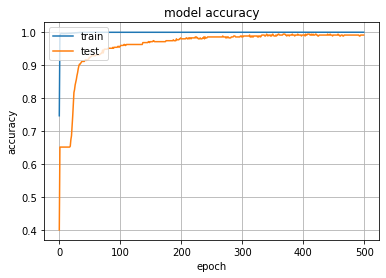

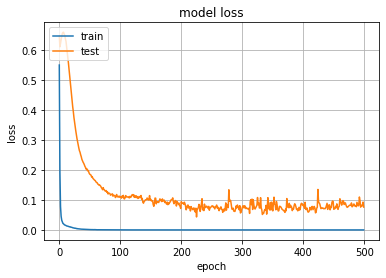

In [89]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.savefig("accuracy.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.savefig("loss.png")
plt.show()

11/11 [==============================] - 0s 4ms/step


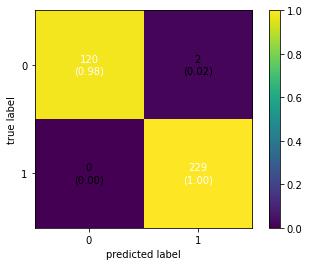

In [90]:
#y_test_pred = model.predict_classes(X_test)
predict_x=model.predict(X_test) 
#y_test_pred=np.argmax(predict_x,axis=1)
#y_test_pred=np.where(predict_x >= 0.5, 1,0)
y_test_pred=np.where(predict_x >= 0.99, 1,0) #this decreases senistivity threshold for detection (needs to be 70% sure)
cm = confusion_matrix(Y_test, y_test_pred)

plot_confusion_matrix(cmap='viridis',
                      conf_mat=cm,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True)
plt.savefig("confusion_matrix.png")
plt.show()

In [91]:
showOnlyIncorrectPredictions = True
print(len(X_test))
for i in range(len(X_test)):
  if y_test_pred[i] != Y_test[i]:
    print('\033[93m', end='')
  if showOnlyIncorrectPredictions == False or y_test_pred[i] != Y_test[i]:
    print(i, end=':')
    print(' Truth: ' + labelsToText[Y_test[i]], end=';')
    print(' Predicted: ' + str(predict_x[i]), end=';')
    print(' FlowName: ' + backLabels[i], end=';')
    print(X_test[i][0:5], end='')
    print('\033[0m')


351
229: Truth: Benign; Predicted: [0.9999981]; FlowName: Src IP: 10.7.22.101 Dest: 10.7.22.22:49667;[[61.55120897293091, 7.78155595923534, 8.395703293828527], [42.138981103897095, 7.201916317531627, 7.543273346705446], [879.1655960083008, 7.78155595923534, 8.390041405755754], [414.7524268627167, 7.78155595923534, 8.395929103923198], [1464.1091389656067, 6.881411303642535, 7.282073658093465]]
255: Truth: Benign; Predicted: [0.9999877]; FlowName: Src IP: 10.7.22.101 Dest: 10.7.22.22:135;[[61.172013998031616, 6.522092798170152, 6.871091294610546], [42.507587909698486, 6.352629396319567, 6.617402977974478], [879.1547272205353, 6.522092798170152, 6.883462586413092], [414.2733178138733, 6.522092798170152, 6.871091294610546], [1464.082515001297, 6.352629396319567, 6.60934924316738]]
